
## Required Libraries And Modules.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import datetime
import json
import os
import logging
import math

import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot

In [ ]:
import pickle


In [ ]:
@keras.saving.register_keras_serializable(package="keras")
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/Long_Data.csv', index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

In [ ]:
df

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,...,0,0,-161,0,0,NaN,NaN,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267163,2024-03-28,44,28453,30049,25833,3139,6562,0,15905,0,...,991,1004,-451,-531,914,1398.0,997.0,1230.0,795.0,0
267164,2024-03-28,45,27089,28693,24637,3023,6562,0,15905,0,...,991,1004,-452,-531,631,1399.0,997.0,789.0,795.0,0
267165,2024-03-28,46,26098,27700,23675,2907,6562,0,15905,0,...,991,1003,-451,-531,611,1398.0,997.0,358.0,793.0,0
267166,2024-03-28,47,24524,26582,22237,2634,6562,0,15905,0,...,947,726,-452,-531,973,1398.0,997.0,488.0,643.0,0


# Data Preprocessing

In [ ]:
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

In [ ]:
df.drop(columns=["nsl_flow", "eleclink_flow","viking_flow","scottish_transfer"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [ ]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [ ]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:10]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25'),
 numpy.datetime64('2009-08-31'),
 numpy.datetime64('2009-12-25'),
 numpy.datetime64('2009-12-26'),
 numpy.datetime64('2009-12-28'),
 numpy.datetime64('2010-01-01')]

In [ ]:
holiday_dates_observed = pd.Series(holiday_dates_observed)
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed.values
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(5)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
57307,2012-04-09,4,26493,28222,23675,854,2019,0,1446,0,908,997,0,994,-321,0,0,1
198951,2020-05-08,16,20165,20935,18005,310,6527,2080,13080,0,4,1510,0,788,-179,-87,757,1
210075,2020-12-26,4,21982,23341,20722,2111,6527,0,13080,0,749,1367,-1,0,145,-9,375,1
180619,2019-04-22,18,23613,24127,20911,1240,6122,3150,13080,0,14,681,0,692,92,292,592,1
34721,2010-12-25,22,43690,44748,39320,451,2141,8,77,0,8,1989,0,0,-450,0,0,1


In [ ]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
248345,2023-03-18,22,10:30:00,27872,29077,25106,815,6545,3044,15278,0,7,1501,991,1003,-450,-148,999,0
153954,2017-10-28,37,18:00:00,34279,34905,32060,3896,5305,2,12372,0,14,1996,0,997,-10,-102,0,0
6986,2009-05-26,29,14:00:00,37372,38241,33977,1319,1673,0,0,0,2,1473,0,0,-367,0,0,0
135995,2016-10-19,28,13:30:00,35053,36490,31703,1237,4856,2480,11433,0,9,-514,0,405,-414,0,0,0
96506,2014-07-19,39,19:00:00,31776,32591,28883,335,3344,466,5016,0,11,1997,0,1029,0,-304,0,0
40698,2011-05-05,1,0:00:00,25990,27884,23371,526,1786,0,159,0,991,527,0,-155,-248,0,0,0
146490,2017-05-26,13,6:00:00,23935,24556,21732,1203,5143,415,12001,0,121,1652,0,725,247,0,0,0


In [ ]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
83769,2013-10-27 09:30:00,20,9:30:00,28429,29161,25890,1440,2392,684,3088,0,10,1491,0,745,-122,349,0,0
252303,2023-06-08 22:30:00,46,22:30:00,23743,26966,21865,1936,6538,0,15552,0,5,-315,-432,-619,-452,-114,-532,0
47023,2011-09-13 18:30:00,38,18:30:00,38037,38545,34337,1360,1836,19,644,0,8,314,0,127,0,0,0,0
43918,2011-07-11 02:00:00,5,2:00:00,22682,24648,20521,154,1828,0,467,0,1228,997,0,267,-238,0,0,0
106840,2015-02-20 02:00:00,5,2:00:00,30262,32626,27797,1074,4136,0,7692,0,1538,1995,0,988,-99,-127,0,0


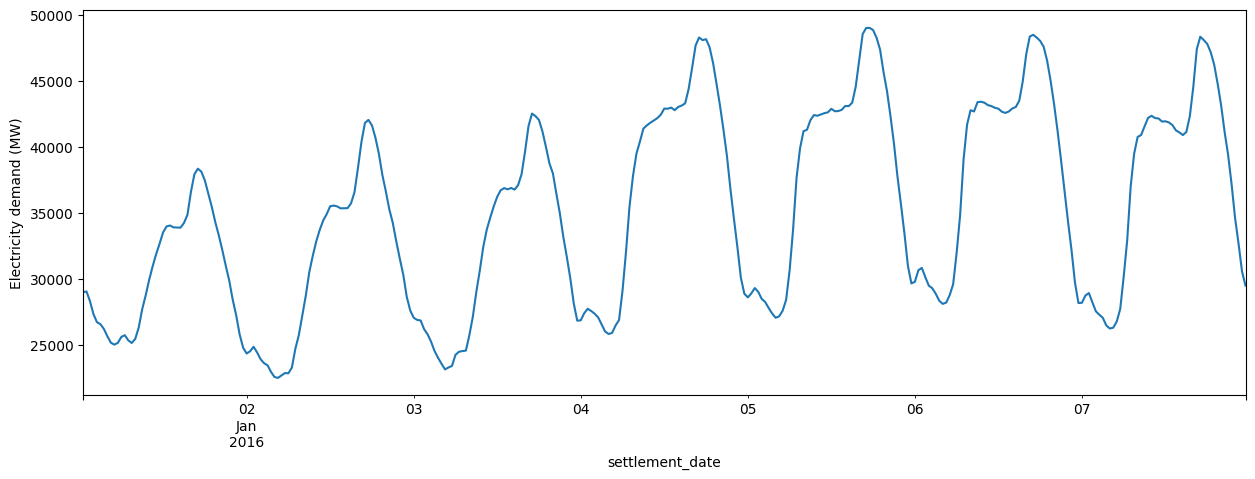

In [ ]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df['date'] = df.index
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], [-1, 602,1300], labels=[0,1])
    return df

# [0, 300, 602, 900, 1300],
#labels=['Spring', 'Summer', 'Fall', 'Winter']
def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [ ]:
df = create_features(df)
df = add_lags(df)


df.sample(n=10)
df[df["year"] == 2022].shape

(17518, 31)

In [ ]:
df_new = df.loc[(df.index>= "01-01-2009") & (df.index < "01-01-24")]

In [ ]:
df_new

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_year,quarter,month,year,week_of_year,date_offset,season,lag1,lag2,lag3
settlement_date,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,...,1,1,1,2009,1,1081,1,NaN,NaN,NaN
2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,...,1,1,1,2009,1,1081,1,NaN,NaN,NaN
2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,...,1,1,1,2009,1,1081,1,NaN,NaN,NaN
2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,...,1,1,1,2009,1,1081,1,NaN,NaN,NaN
2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,...,1,1,1,2009,1,1081,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:30:00,44,21:30:00,25269,25921,22546,2707,6488,0,15905,0,...,365,4,12,2023,52,911,1,26756.0,26645.0,32316.0
2023-12-31 22:00:00,45,22:00:00,24254,24977,21608,2734,6488,0,15905,0,...,365,4,12,2023,52,911,1,25754.0,26569.0,30963.0
2023-12-31 22:30:00,46,22:30:00,23455,24134,20889,2761,6488,0,15905,0,...,365,4,12,2023,52,911,1,24790.0,25901.0,29427.0


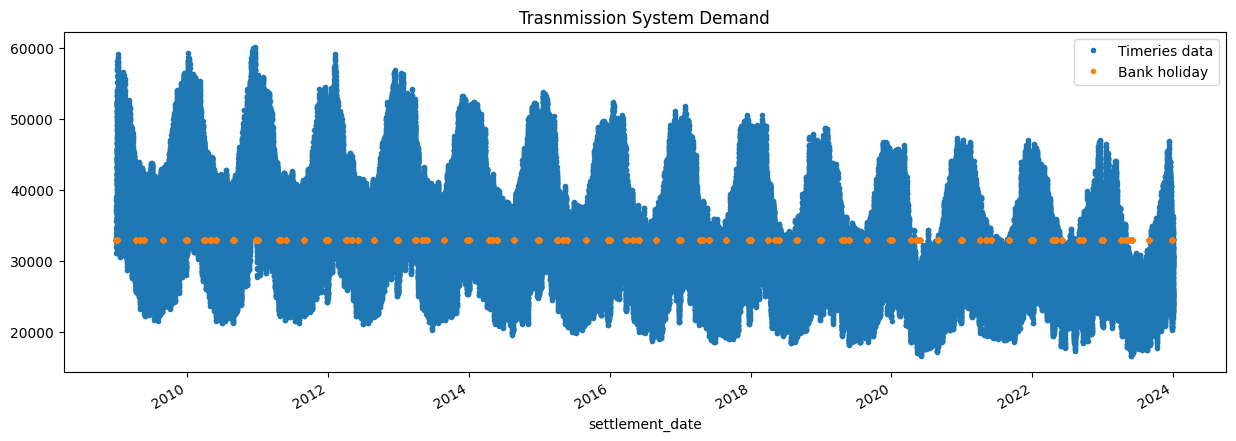

In [ ]:
# Set date as the index and turn into datetime type
df_plot = df_new

df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"]*33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

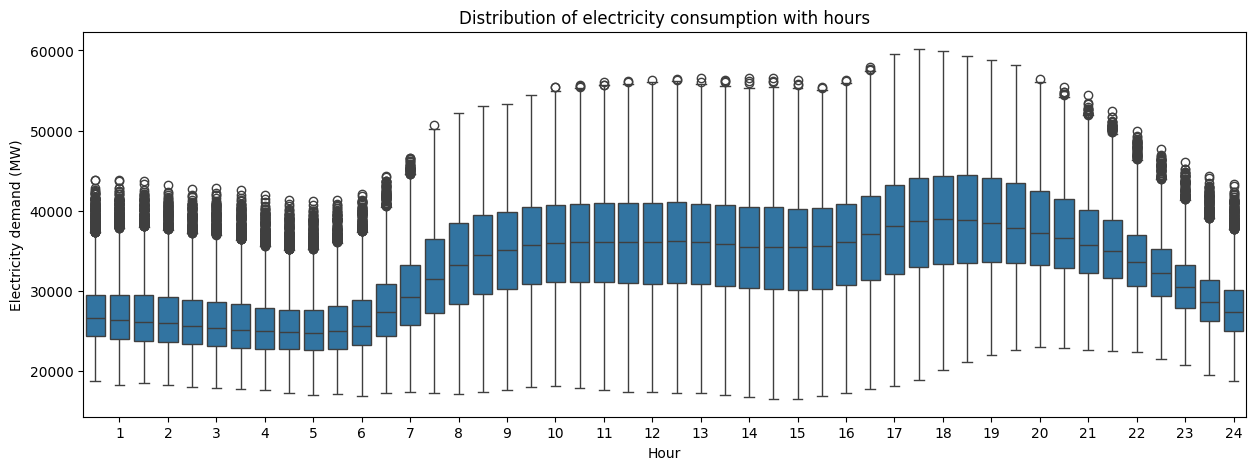

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

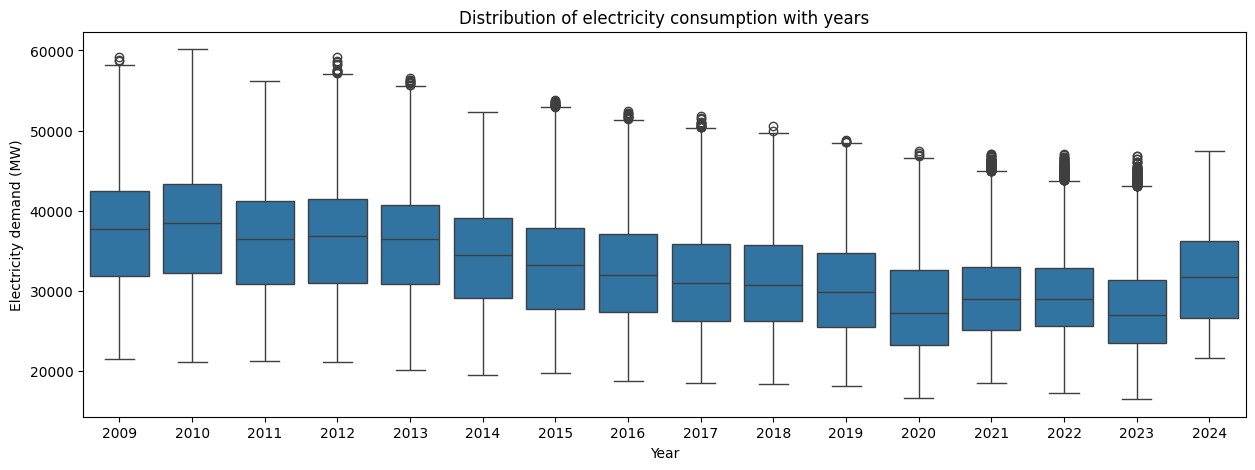

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

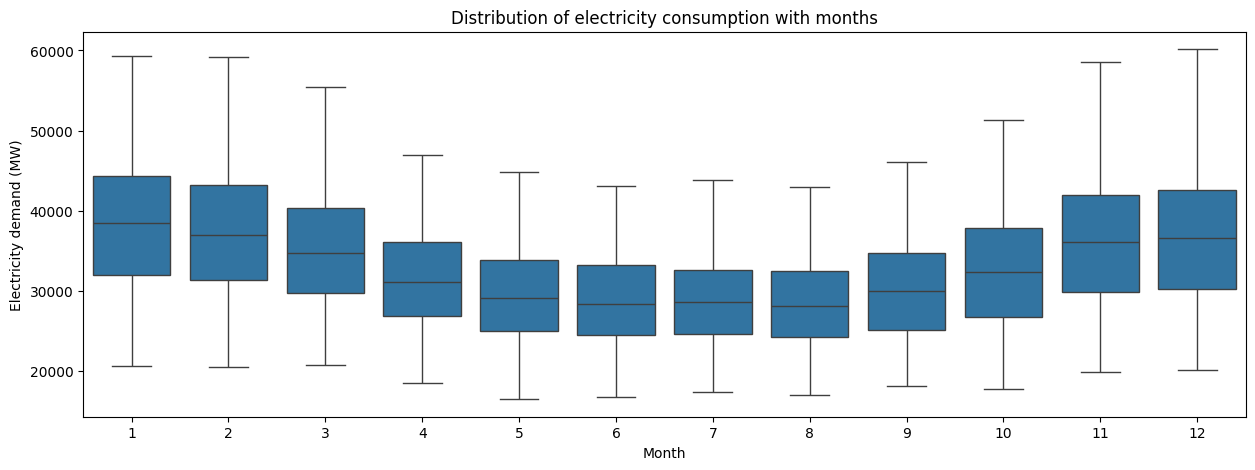

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

<ipython-input-24-8fa42bc6c1a6>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


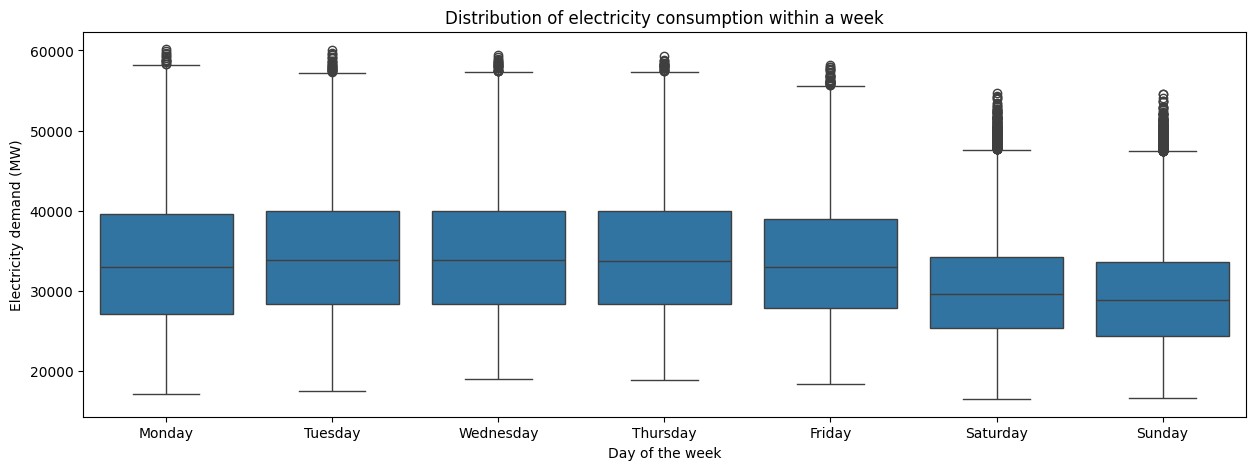

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption within a week");

<ipython-input-25-a43933627e79>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


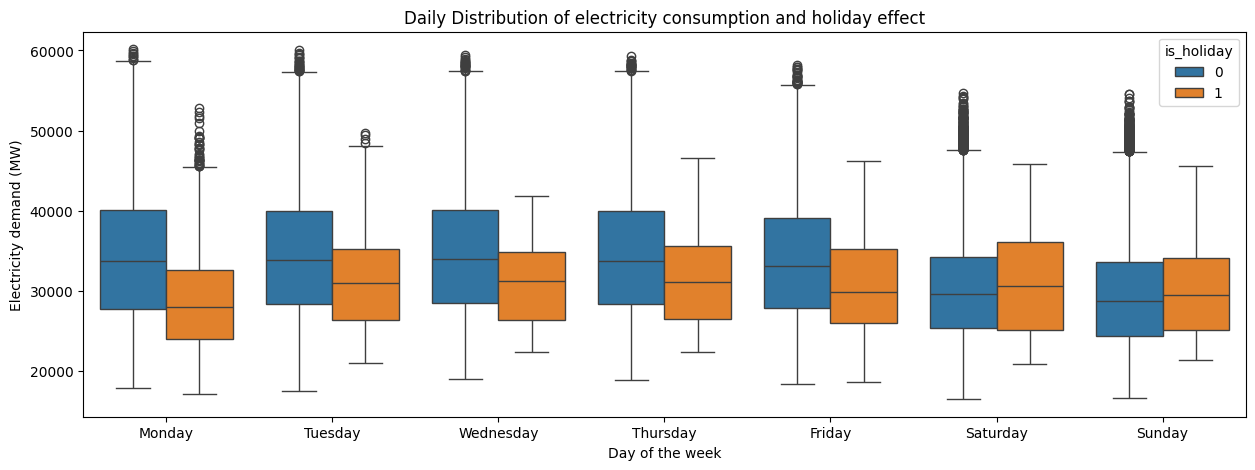

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

In [ ]:
df

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_year,quarter,month,year,week_of_year,date_offset,season,lag1,lag2,lag3
settlement_date,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,...,1,1,1,2009,1,1081,1,NaN,NaN,NaN
2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,...,1,1,1,2009,1,1081,1,NaN,NaN,NaN
2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,...,1,1,1,2009,1,1081,1,NaN,NaN,NaN
2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,...,1,1,1,2009,1,1081,1,NaN,NaN,NaN
2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,...,1,1,1,2009,1,1081,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28 21:30:00,44,21:30:00,28453,30049,25833,3139,6562,0,15905,0,...,88,1,3,2024,13,8,0,29649.0,33588.0,30389.0
2024-03-28 22:00:00,45,22:00:00,27089,28693,24637,3023,6562,0,15905,0,...,88,1,3,2024,13,8,0,28149.0,31651.0,28754.0
2024-03-28 22:30:00,46,22:30:00,26098,27700,23675,2907,6562,0,15905,0,...,88,1,3,2024,13,8,0,26801.0,29899.0,27195.0


# General Functions

In [ ]:
def settlement_period(df):
    """
    Determine settlement period using dataframe index date. Each settlement period
    equates to 30-minute interval.
    Settlement period equal to 0 corresponds with 00:00:00 and settlement period 48
    corresponds with 23:30:00

    Args:
        - df: time series dataframe containing dates in the future

    Returns:
        - df: time series dataframe with settlement period column
    """

    df = df.copy()

    settlement_period_array = (
        np.array(df.index.hour.to_list()) * 2 + np.array(df.index.minute.to_list()) / 30 + 1
    ).astype(int)


    df["settlement_period"] = settlement_period_array

    return df

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

# **XGB + GridSearch_CV**




In [ ]:
Start = "01-01-2012"
threshold_date_1 = "28-03-2023"
threshold_date_2 = "28-03-2024"
train_data = df.loc[(df.index>= Start) & (df.index < threshold_date_1)]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

In [ ]:
train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "tsd"

# Define train, test and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]


In [ ]:
X_train_cv

,settlement_period,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3,is_holiday
settlement_date,,,,,,,,,,,,
2012-01-01 00:00:00,1,1,6,1,1,1,2012,52,34179.0,36710.0,38749.0,1
2012-01-01 00:30:00,2,1,6,1,1,1,2012,52,34017.0,36559.0,38318.0,1
2012-01-01 01:00:00,3,1,6,1,1,1,2012,52,33722.0,36240.0,37621.0,1
2012-01-01 01:30:00,4,1,6,1,1,1,2012,52,33035.0,35468.0,36664.0,1
2012-01-01 02:00:00,5,1,6,1,1,1,2012,52,32807.0,34889.0,36079.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27 21:30:00,44,27,0,86,1,3,2023,13,31928.0,29285.0,30753.0,0
2023-03-27 22:00:00,45,27,0,86,1,3,2023,13,30704.0,27552.0,29326.0,0
2023-03-27 22:30:00,46,27,0,86,1,3,2023,13,29004.0,26005.0,28097.0,0


In [ ]:
df["tsd"].max()

60147

In [ ]:
X_train_cv

,settlement_period,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3,is_holiday
settlement_date,,,,,,,,,,,,
2012-01-01 00:00:00,1,1,6,1,1,1,2012,52,34179.0,36710.0,38749.0,1
2012-01-01 00:30:00,2,1,6,1,1,1,2012,52,34017.0,36559.0,38318.0,1
2012-01-01 01:00:00,3,1,6,1,1,1,2012,52,33722.0,36240.0,37621.0,1
2012-01-01 01:30:00,4,1,6,1,1,1,2012,52,33035.0,35468.0,36664.0,1
2012-01-01 02:00:00,5,1,6,1,1,1,2012,52,32807.0,34889.0,36079.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27 21:30:00,44,27,0,86,1,3,2023,13,31928.0,29285.0,30753.0,0
2023-03-27 22:00:00,45,27,0,86,1,3,2023,13,30704.0,27552.0,29326.0,0
2023-03-27 22:30:00,46,27,0,86,1,3,2023,13,29004.0,26005.0,28097.0,0


In [ ]:
MXGB = pickle.load(open('/content/drive/MyDrive/data/XGB_Search_model','rb'))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:01:59] WARNING: /workspace/src/gbm/gbtree.cc:360: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:01:59] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:01:59] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


In [ ]:
result_frame1=pd.DataFrame()
result_frame1["tsd"]= MXGB.predict(X_test_cv)

In [ ]:
result_frame1

,tsd
0,24338.791016
1,24213.691406
2,24549.093750
3,24677.255859
4,24668.437500
...,...
17563,30609.597656
17564,29123.787109
17565,27521.292969
17566,25841.582031


In [ ]:
df.index.min()

Timestamp('2009-01-01 00:00:00')

In [ ]:

def xgb_prediction(str1,prediction_days,df):
    FEATURES_CV = [
        "settlement_period",
        "day_of_month",
        "day_of_week",
        "day_of_year",
        "quarter",
        "month",
        "year",
        "week_of_year",
        "lag1",
        "lag2",
        "lag3",
        "is_holiday",
    ]

    date_object = datetime.datetime.fromisoformat(str1)
    future = pd.date_range(
        str(date_object)[0:10],
        date_object + datetime.timedelta(days=prediction_days),
        freq="30min",
    )

    future_df = pd.DataFrame(index=future)
    future_df = settlement_period(future_df)
    future_df["is_future"] = True
    df["is_future"] = False

    # Create a dataframe containing the original data and the predict df
    df_and_future = pd.concat([df, future_df])

    yr = int(str1[:4])

    if(prediction_days>366):
      yfh = math.ceil(prediction_days/365)
    else:
      yfh = 2

    bank_holiday_england = holidays.UK(subdiv="England", years=range(yr,yr+yfh), observed=True).items()


    holiday_names = []
    holiday_dates = []
    holiday_names_observed = []
    holiday_dates_observed = []

    for date, name in sorted(bank_holiday_england):
        holiday_dates.append(date)
        holiday_names.append(name)
        # Pop the previous value as observed bank holidays takes place later
        if "Observed" in name:
            holiday_dates_observed.pop()
            holiday_names_observed.pop()

        holiday_names_observed.append(name)
        holiday_dates_observed.append(np.datetime64(date))


    # add features and lag
    # lag values will change w.r.t original dataframe
    df_and_future = create_features(df_and_future)
    df_and_future = add_lags(df_and_future)

    # add bank holidays in future dataframe
    df_and_future_wprediction = df_and_future.query("is_future").copy()

    df_and_future_wprediction["settlement_date"] = df_and_future_wprediction.index.date
    holiday_dates_observed = pd.Series(holiday_dates_observed)



    df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["settlement_date"].apply(
        lambda x: pd.to_datetime(x) in holiday_dates_observed.values
    )
    df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["is_holiday"].astype(int)


    df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["is_holiday"].astype(int)

    df_and_future_wprediction["tsd"] = MXGB.predict(
        df_and_future_wprediction[FEATURES_CV]
    )

    return df_and_future_wprediction


**XGB + Grid_search_CV Predictions**

In [ ]:
str1="2025-01-01"
prediction_days=365
df_xgb= xgb_prediction(str1,prediction_days,df)

In [ ]:
df_xgb

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,month,year,week_of_year,date_offset,season,lag1,lag2,lag3,is_future,settlement_date
2025-01-01 00:00:00,1,NaN,NaN,24000.605469,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2025,1,1081,1,25678.0,25119.0,27309.0,True,2025-01-01
2025-01-01 00:30:00,2,NaN,NaN,24158.369141,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2025,1,1081,1,25865.0,25503.0,27722.0,True,2025-01-01
2025-01-01 01:00:00,3,NaN,NaN,24049.527344,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2025,1,1081,1,25665.0,25573.0,27724.0,True,2025-01-01
2025-01-01 01:30:00,4,NaN,NaN,23869.875000,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2025,1,1081,1,25488.0,25088.0,27430.0,True,2025-01-01
2025-01-01 02:00:00,5,NaN,NaN,23858.595703,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2025,1,1081,1,24908.0,25210.0,27272.0,True,2025-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-31 22:00:00,45,NaN,NaN,33141.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2025,1,911,1,NaN,29677.0,27984.0,True,2025-12-31
2025-12-31 22:30:00,46,NaN,NaN,32045.876953,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2025,1,911,1,NaN,28020.0,26911.0,True,2025-12-31
2025-12-31 23:00:00,47,NaN,NaN,30655.593750,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2025,1,911,1,NaN,26270.0,25822.0,True,2025-12-31
2025-12-31 23:30:00,48,NaN,NaN,30510.789062,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2025,1,911,1,NaN,25389.0,25438.0,True,2025-12-31


In [ ]:
check = pd.DataFrame()
threshold_date_s = "31-03-2024"
threshold_date_e = "28-04-2024"
check = df_xgb.loc[(df_xgb.index>= threshold_date_s) & (df_xgb.index < threshold_date_e)]

In [ ]:
check.head(50)

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,month,year,week_of_year,date_offset,season,lag1,lag2,lag3,is_future,settlement_date


In [ ]:
df_xgb["is_holiday"]==0

2025-01-01 00:00:00    False
2025-01-01 00:30:00    False
2025-01-01 01:00:00    False
2025-01-01 01:30:00    False
2025-01-01 02:00:00    False
                       ...  
2025-12-31 22:00:00     True
2025-12-31 22:30:00     True
2025-12-31 23:00:00     True
2025-12-31 23:30:00     True
2026-01-01 00:00:00    False
Name: is_holiday, Length: 17521, dtype: bool

In [ ]:
len(df_xgb[df_xgb["is_holiday"] == 0])


17136

# **Combine with LSTM**


In [ ]:
Start = "01-01-2012"
threshold_date_1 = "31-12-2023"
threshold_date_2 = "28-03-2024"
train_data = df.loc[(df.index>= Start) & (df.index < threshold_date_1)]
#train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]



# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "season"

]
TARGET = "tsd"

FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train = train_data[FEATURES_TARGET]
test = test_data[FEATURES_TARGET]

##
test1=test.copy()
test1=test.reset_index()
test1.update(result_frame1)
test1.set_index("settlement_date", inplace=True)
test1.sort_index(inplace=True)
##



y_test=test_data["tsd"]

scaler = MinMaxScaler(feature_range=(0,1))
train_s = scaler.fit_transform(train)
test_s = scaler.transform(test1)


X_train =  train_s[:,:]

y_train = train_s[:,-1]

X_test = test_s[:,:]

y_test = test_s[:,-1]

In [ ]:
train

,is_holiday,settlement_period,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,season,tsd
settlement_date,,,,,,,,,,,
2012-01-01 00:00:00,1,1,1,6,1,1,1,2012,52,1,31262
2012-01-01 00:30:00,1,2,1,6,1,1,1,2012,52,1,31163
2012-01-01 01:00:00,1,3,1,6,1,1,1,2012,52,1,30594
2012-01-01 01:30:00,1,4,1,6,1,1,1,2012,52,1,30011
2012-01-01 02:00:00,1,5,1,6,1,1,1,2012,52,1,29441
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 21:30:00,0,44,30,5,364,4,12,2023,52,1,27571
2023-12-30 22:00:00,0,45,30,5,364,4,12,2023,52,1,26506
2023-12-30 22:30:00,0,46,30,5,364,4,12,2023,52,1,25915


In [ ]:
df[df["season"].isnull()]

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,quarter,month,year,week_of_year,date_offset,season,lag1,lag2,lag3,is_future
settlement_date,,,,,,,,,,,,,,,,,,,,,


In [ ]:
test

,is_holiday,settlement_period,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,season,tsd
settlement_date,,,,,,,,,,,
2023-03-28 00:00:00,0,1,28,1,87,1,3,2023,13,0,23172
2023-03-28 00:30:00,0,2,28,1,87,1,3,2023,13,0,22998
2023-03-28 01:00:00,0,3,28,1,87,1,3,2023,13,0,23083
2023-03-28 01:30:00,0,4,28,1,87,1,3,2023,13,0,23768
2023-03-28 02:00:00,0,5,28,1,87,1,3,2023,13,0,24483
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27 21:30:00,0,44,27,2,87,1,3,2024,13,0,32339
2024-03-27 22:00:00,0,45,27,2,87,1,3,2024,13,0,30109
2024-03-27 22:30:00,0,46,27,2,87,1,3,2024,13,0,28450


In [ ]:
test1.shape

(17568, 11)

In [ ]:
len(test[test["is_holiday"] == 1])

384

In [ ]:
win_length=48
batch_size=32
num_features=11


train_generator=TimeseriesGenerator(X_train,y_train,length=win_length,sampling_rate=1,batch_size=batch_size)



test_generator=TimeseriesGenerator(X_test,y_test,length=win_length,sampling_rate=1,batch_size=batch_size)

In [ ]:
MLSTM = pickle.load(open('/content/drive/MyDrive/data/LSTM_LongTerm_48','rb'))

In [ ]:
pred = MLSTM.predict_generator(test_generator)

<ipython-input-53-20c60bc4481d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = MLSTM.predict_generator(test_generator)


In [ ]:
df_pred=pd.concat([pd.DataFrame(X_test[:,:10][win_length:]),pd.DataFrame(pred)],axis=1)

In [ ]:
rev_trans=scaler.inverse_transform(df_pred)

In [ ]:
frames=[train,test]
df_input= pd.concat(frames)

In [ ]:
df_final=df_input[pred.shape[0]*-1:]

In [ ]:
df_final['Predicted']= rev_trans[:,10]

<ipython-input-58-73b2436cc57c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Predicted']= rev_trans[:,10]


In [ ]:
df_final

,is_holiday,settlement_period,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,season,tsd,Predicted
settlement_date,,,,,,,,,,,,
2023-03-29 00:00:00,0,1,29,2,88,1,3,2023,13,0,24505,23548.975895
2023-03-29 00:30:00,0,2,29,2,88,1,3,2023,13,0,24081,23452.966975
2023-03-29 01:00:00,0,3,29,2,88,1,3,2023,13,0,24427,22816.788257
2023-03-29 01:30:00,0,4,29,2,88,1,3,2023,13,0,24693,22845.563473
2023-03-29 02:00:00,0,5,29,2,88,1,3,2023,13,0,24884,23771.654999
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27 21:30:00,0,44,27,2,87,1,3,2024,13,0,32339,28709.878829
2024-03-27 22:00:00,0,45,27,2,87,1,3,2024,13,0,30109,27555.056234
2024-03-27 22:30:00,0,46,27,2,87,1,3,2024,13,0,28450,26191.236937


In [ ]:
test=test[win_length:]

In [ ]:
test.shape

(17520, 11)

In [ ]:
df_final.shape

(17520, 12)

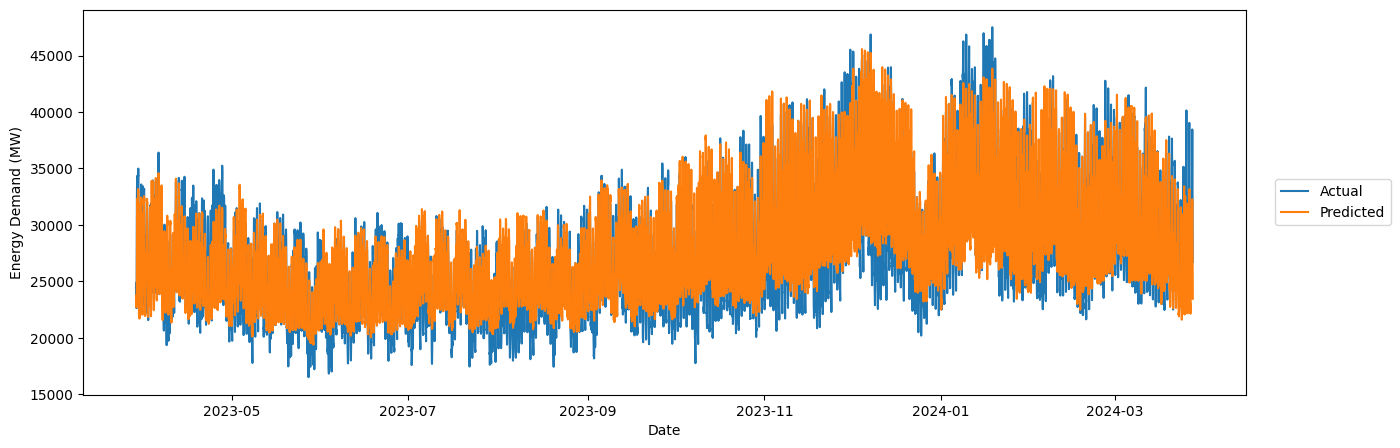

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_final.index, test["tsd"], label="Actual")
ax.plot(df_final.index, df_final["Predicted"],  label="Predicted")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))


ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

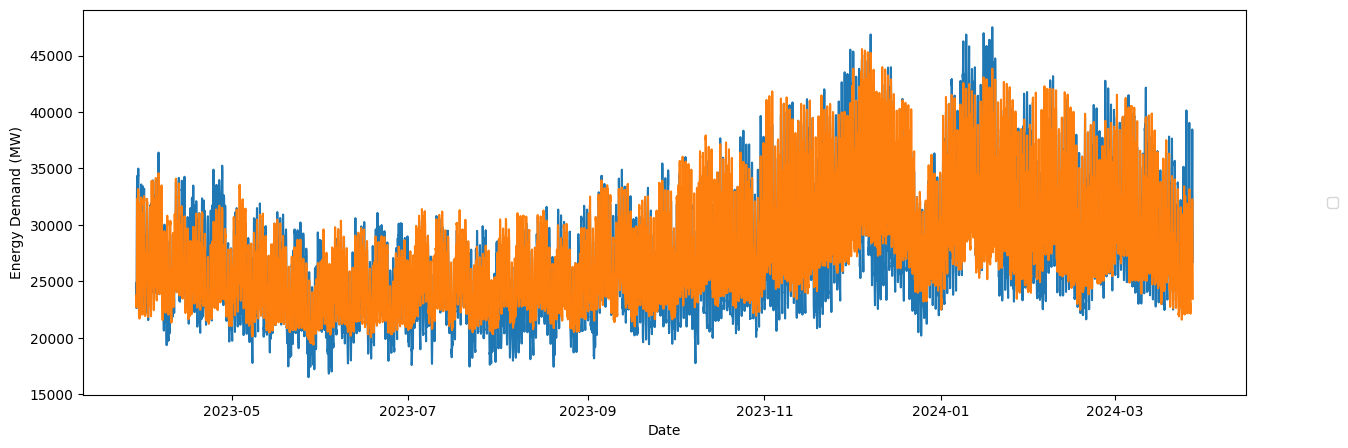

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_final.index, test["tsd"])
ax.plot(df_final.index, df_final["Predicted"])

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))


ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
test["tsd"].isnull()

settlement_date
2023-03-29 00:00:00    False
2023-03-29 00:30:00    False
2023-03-29 01:00:00    False
2023-03-29 01:30:00    False
2023-03-29 02:00:00    False
                       ...  
2024-03-27 21:30:00    False
2024-03-27 22:00:00    False
2024-03-27 22:30:00    False
2024-03-27 23:00:00    False
2024-03-27 23:30:00    False
Name: tsd, Length: 17520, dtype: bool

In [ ]:
count =df_final["Predicted"].isnull().sum()
count

0

In [ ]:
df_final[df_final["Predicted"].isnull()]

,is_holiday,settlement_period,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,season,tsd,Predicted
settlement_date,,,,,,,,,,,,


In [ ]:
mape_deep_lstm = mean_absolute_percentage_error(
    df_final["Predicted"],df_final["tsd"]
)

rmse_deep_lstm = np.sqrt(mean_squared_error(df_final["tsd"], df_final["Predicted"]))

print(
    "Mean Absolute Percentage Error of the Final model is: %.2f" % mape_deep_lstm
)

print(
    "Root Mean Squared Error of the Final model is: %.2f MW" % rmse_deep_lstm
)


Mean Absolute Percentage Error of the Final model is: 6.53
Root Mean Squared Error of the Final model is: 2353.12 MW


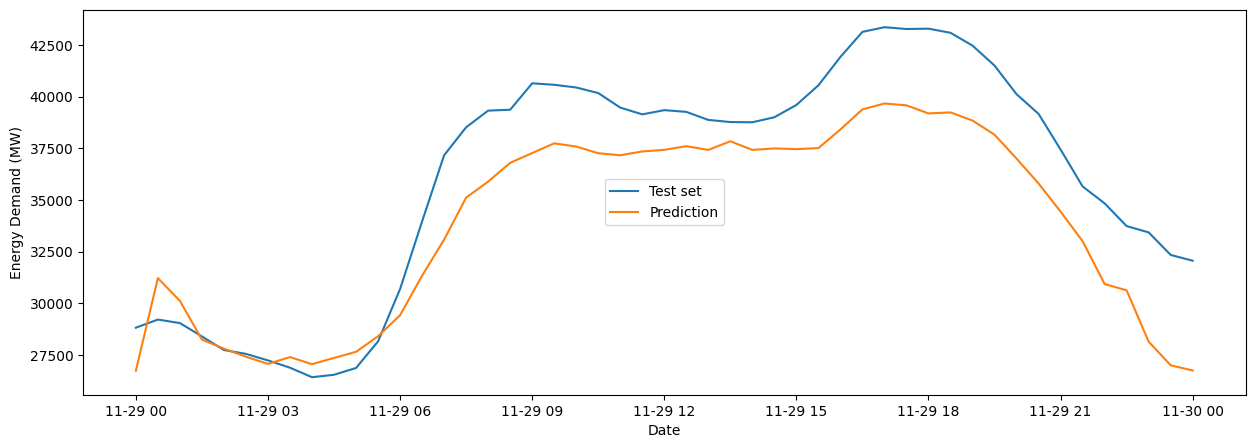

In [ ]:
d1 = "29-11-2023"
d2 = "30-11-2023"
df_final1 = df_final.loc[(df_final.index>=d1) & (df_final.index <= d2)]

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_final1.index, df_final1["tsd"], "-", label="Test set")
ax.plot(df_final1.index, df_final1["Predicted"], "-", label="Prediction")

ax.legend(loc="center")


ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

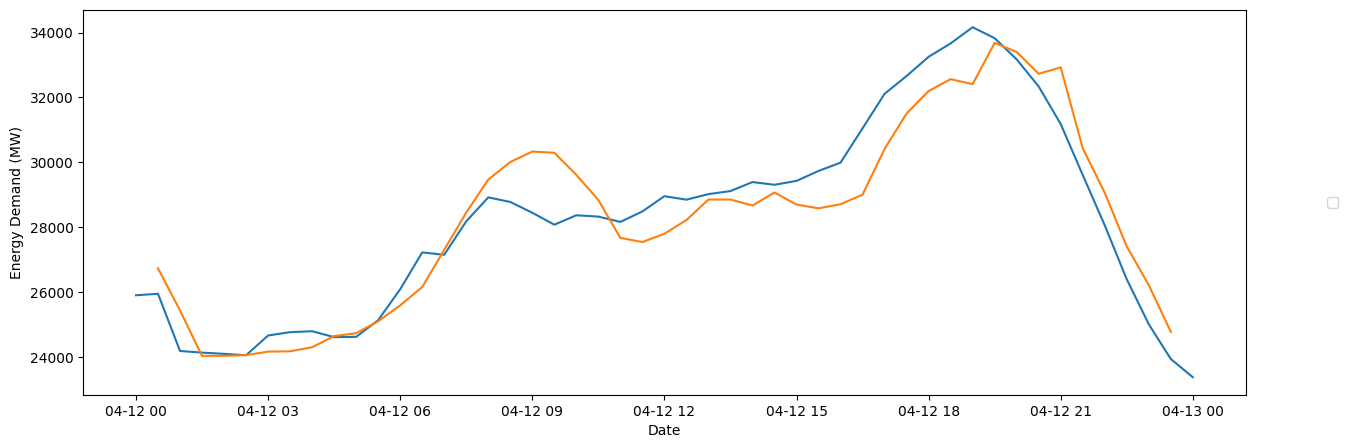

In [ ]:
begin = "2023-04-12"
end = "2023-04-13"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    df_final.loc[(df_final.index >= begin) & (df_final.index <= end)].index,
    df_final.loc[(df_final.index >= begin) & (df_final.index <= end)]["tsd"],
    "-",

)


ax.plot(
    df_final.loc[(df_final.index > begin) & (df_final.index < end)].index,
    df_final.loc[(df_final.index > begin) & (df_final.index < end)][
        "Predicted"
    ],
    "-",

)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))


ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

# Future Prediction

In [ ]:
def Future_prediction(df_xgb):
    FEATURES = [
        "is_holiday",
        "settlement_period",
        "day_of_month",
        "day_of_week",
        "day_of_year",
        "quarter",
        "month",
        "year",
        "week_of_year",
        "season"

    ]
    TARGET = "tsd"

    FEATURES_TARGET = FEATURES.copy()
    FEATURES_TARGET.append(TARGET)

    test = df_xgb[FEATURES_TARGET]

    scaler = MinMaxScaler(feature_range=(0,1))

    test_s = scaler.fit_transform(test)



    X_test = test_s[:,:]

    y_test = test_s[:,-1]

    win_length=48
    batch_size=32
    num_features=11


    test_generator=TimeseriesGenerator(X_test,y_test,length=win_length,sampling_rate=1,batch_size=batch_size)
    pred = MLSTM.predict_generator(test_generator)
    df_pred=pd.concat([pd.DataFrame(X_test[:,:10][win_length:]),pd.DataFrame(pred)],axis=1)
    rev_trans=scaler.inverse_transform(df_pred)
    df_final=df_xgb[pred.shape[0]*-1:]
    df_final['Predicted TSD']= rev_trans[:,10]
    FEATURE_Final = [
        "is_holiday",
        "settlement_period",
        "day_of_month",
        "day_of_week",
        "day_of_year",
        "quarter",
        "month",
        "year",
        "week_of_year",
        "season",
        "Predicted TSD"

    ]

    return df_final[FEATURE_Final]

In [ ]:
print(df_final.index.name)

settlement_date


In [ ]:
df_final=Future_prediction(df_xgb)

<ipython-input-71-374d12fbbc81>:38: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = MLSTM.predict_generator(test_generator)
<ipython-input-71-374d12fbbc81>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Predicted TSD']= rev_trans[:,10]


In [ ]:
df_final

,is_holiday,settlement_period,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,season,Predicted TSD
2025-01-02 00:00:00,0,1,2,3,2,1,1,2025,1,1,23906.778457
2025-01-02 00:30:00,0,2,2,3,2,1,1,2025,1,1,23696.995913
2025-01-02 01:00:00,0,3,2,3,2,1,1,2025,1,1,25166.407182
2025-01-02 01:30:00,0,4,2,3,2,1,1,2025,1,1,28347.055356
2025-01-02 02:00:00,0,5,2,3,2,1,1,2025,1,1,27147.936680
...,...,...,...,...,...,...,...,...,...,...,...
2025-12-31 22:00:00,0,45,31,2,365,4,12,2025,1,1,31723.690729
2025-12-31 22:30:00,0,46,31,2,365,4,12,2025,1,1,31246.067274
2025-12-31 23:00:00,0,47,31,2,365,4,12,2025,1,1,29773.141570
2025-12-31 23:30:00,0,48,31,2,365,4,12,2025,1,1,28549.911631


# **Final Work**

In [ ]:
str1="2023-01-01"
days=365
df_xgb= xgb_prediction(str1,days,df)
df_final=Future_prediction(df_xgb)

<ipython-input-71-374d12fbbc81>:38: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = MLSTM.predict_generator(test_generator)
<ipython-input-71-374d12fbbc81>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Predicted TSD']= rev_trans[:,10]


In [ ]:
df_final

,is_holiday,settlement_period,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,season,Predicted TSD
2023-01-02 00:00:00,1,1,2,0,2,1,1,2023,1,1,23029.904017
2023-01-02 00:30:00,1,2,2,0,2,1,1,2023,1,1,22351.676012
2023-01-02 01:00:00,1,3,2,0,2,1,1,2023,1,1,22562.815470
2023-01-02 01:30:00,1,4,2,0,2,1,1,2023,1,1,23106.005071
2023-01-02 02:00:00,1,5,2,0,2,1,1,2023,1,1,23755.188299
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 22:00:00,0,45,31,6,365,4,12,2023,52,1,30326.699736
2023-12-31 22:30:00,0,46,31,6,365,4,12,2023,52,1,29525.999490
2023-12-31 23:00:00,0,47,31,6,365,4,12,2023,52,1,28955.221670
2023-12-31 23:30:00,0,48,31,6,365,4,12,2023,52,1,27858.152107


In [ ]:
str1="2024-01-01"
days= 365
df_xgb= xgb_prediction(str1,days,df)
df_final=Future_prediction(df_xgb)

<ipython-input-71-374d12fbbc81>:38: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = MLSTM.predict_generator(test_generator)
<ipython-input-71-374d12fbbc81>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Predicted TSD']= rev_trans[:,10]


In [ ]:
df_xgb

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,month,year,week_of_year,date_offset,season,lag1,lag2,lag3,is_future,settlement_date
2024-01-01 00:00:00,1,NaN,NaN,23300.037109,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2024,1,1081,1,22893.0,23868.0,26621.0,True,2024-01-01
2024-01-01 00:30:00,2,NaN,NaN,23419.861328,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2024,1,1081,1,23300.0,24335.0,26802.0,True,2024-01-01
2024-01-01 01:00:00,3,NaN,NaN,23346.142578,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2024,1,1081,1,22889.0,24335.0,26880.0,True,2024-01-01
2024-01-01 01:30:00,4,NaN,NaN,23267.757812,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2024,1,1081,1,22506.0,23799.0,26544.0,True,2024-01-01
2024-01-01 02:00:00,5,NaN,NaN,23114.791016,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2024,1,1081,1,22093.0,23206.0,26112.0,True,2024-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 22:00:00,45,NaN,NaN,33285.085938,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2024,1,910,1,NaN,28241.0,28729.0,True,2024-12-30
2024-12-30 22:30:00,46,NaN,NaN,32017.404297,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2024,1,910,1,NaN,26600.0,27431.0,True,2024-12-30
2024-12-30 23:00:00,47,NaN,NaN,30865.359375,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2024,1,910,1,NaN,25135.0,26090.0,True,2024-12-30
2024-12-30 23:30:00,48,NaN,NaN,30706.857422,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2024,1,910,1,NaN,24018.0,25281.0,True,2024-12-30


In [ ]:
df_final

,is_holiday,settlement_period,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,season,Predicted TSD
2024-01-02 00:00:00,0,1,2,1,2,1,1,2024,1,1,23121.724181
2024-01-02 00:30:00,0,2,2,1,2,1,1,2024,1,1,24337.222878
2024-01-02 01:00:00,0,3,2,1,2,1,1,2024,1,1,25403.344580
2024-01-02 01:30:00,0,4,2,1,2,1,1,2024,1,1,27151.195157
2024-01-02 02:00:00,0,5,2,1,2,1,1,2024,1,1,26509.578179
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 22:00:00,0,45,30,0,365,4,12,2024,1,1,31684.710023
2024-12-30 22:30:00,0,46,30,0,365,4,12,2024,1,1,30779.783981
2024-12-30 23:00:00,0,47,30,0,365,4,12,2024,1,1,29406.080439
2024-12-30 23:30:00,0,48,30,0,365,4,12,2024,1,1,28333.916611


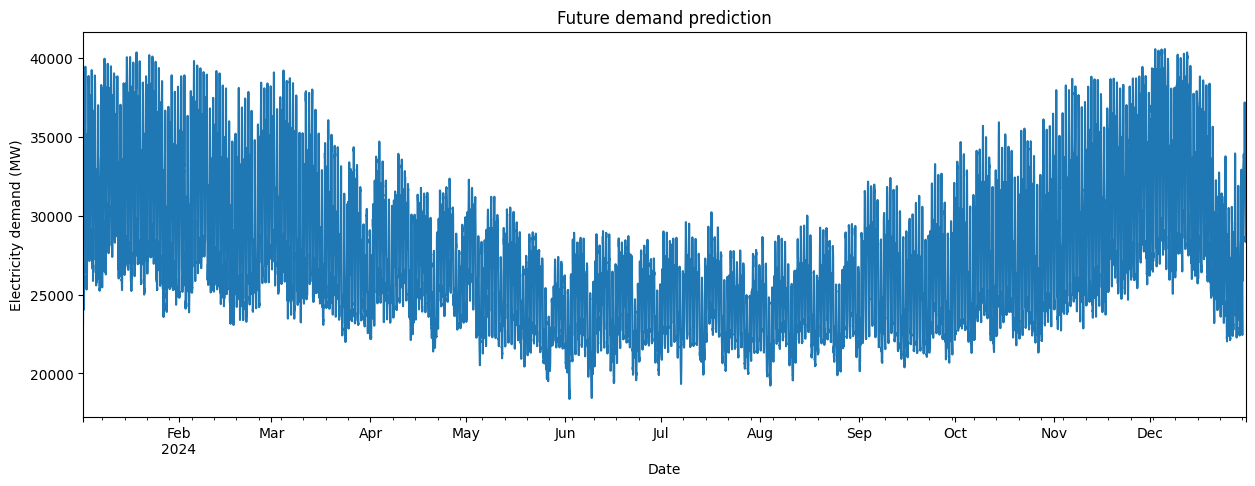

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
df_final["Predicted TSD"].plot(figsize=(15, 5), style="-", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

In [ ]:
df_final['Predicted'].plot(figsize=(20,5),linewidth=1.2,cmap='cool',ylabel='MW',title='Electricity Demand')

# Interface


In [ ]:
pip install pyngrok

In [ ]:
def calculate_days(str1,str2):

    # Parse the dates from strings into datetime objects
    date1 = datetime.datetime.strptime(str1, "%Y-%m-%d")
    date2 = datetime.datetime.strptime(str2, "%Y-%m-%d")
    if date2 > date1:
        return (date2-date1).days
    else:
        return (date1-date2).days

In [ ]:
from google.colab import output
output.serve_kernel_port_as_window(5000)

In [ ]:
import numpy as np

from pyngrok import ngrok
from flask import Flask, request, render_template
import pickle
from dateutil import relativedelta

static_folder="/content/drive/MyDrive/Model Deployment/templates/static"
templates_folder="/content/drive/MyDrive/Model Deployment/templates"
port_no=5000
app = Flask(__name__,template_folder=templates_folder,static_folder=static_folder)
ngrok.set_auth_token("2gN2awEDIVlsBoFmJBQPs1fE17I_51Vp6QtkMnoz8KkPiw1za")
public_url = ngrok.connect(port_no).public_url
print(public_url)


@app.route('/')
def home():
    return render_template('demand_forecast.html')


@app.route('/getprediction',methods=['POST','GET'])
def getprediction():
    if request.method=='POST':
      #input
      input = [str(x) for x in request.form.values()]
      str1=input[0]
      str2=input[1]
      days=calculate_days(str1,str2)
      st = str(datetime.datetime.strptime(str1, "%Y-%m-%d"))
      if(days):
         df_xgb= xgb_prediction(st,days,df)
         df_final=Future_prediction(df_xgb)
         return render_template('test.html',tables=[df_final.to_html(classes='data')],titles=df_final.columns.values)
      else:
        return render_template('demand_forecast.html')



    #df_xgb= xgb_prediction(days,df)
    #df_final=Future_prediction(df_xgb)
    else:
      return render_template('demand_forecast.html')








app.run(port=port_no)